<a href="https://colab.research.google.com/github/Lily3-2/legal-ease/blob/master/BART_with_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The provided code implements a text summarization model using the BART(Bidirectional and Auto-Regressive Transformers) model.**

The primary objective of this model is to generate concise and coherent summaries of legal cases. It aims to provide a summarized version of the input text while retaining the essential information and context, making it easier and quicker for legal professionals to review and understand the cases.



# 1. Installing and importing Required Libraries

In [1]:
!pip install datasets evaluate rouge_score
!pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=e1b58c8707988db2ae2c1a07e67045b1ce6081a3e6580457dbf17145010074ad
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-

In [2]:
#import libraries
import os
import pandas as pd

# 2. Setting Hyperparameters

In [3]:
# Set hyperparameters
BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 64
TRAINING_DATASET_SIZE = 100
TESTING_DATASET_SIZE = 10

DATASET_PATH = "/content/train.csv"
TEST_DATASET_PATH = "/content/test.csv"

#CHANGE THIS BEFORE ANY HYPERPARAMETER CHANGE !!!!!!!!!!!!
OUTPUT_DIR_CHECKPOINT = "/content/cache"

# 3. Load the Data

In [4]:
from datasets import load_dataset

# Load the dataset
legal_data = load_dataset("csv", data_files={"train": DATASET_PATH, "test": TEST_DATASET_PATH})

legal_data["train"] = legal_data["train"].select(range(TRAINING_DATASET_SIZE))
legal_data["test"] = legal_data["test"].select(range(TESTING_DATASET_SIZE))

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Accessing a Sample from the Training Dataset
First sample from the training dataset, which includes the "Title", "summary" and "Case" fields based on the structure of the dataset.

In [5]:
legal_data["train"][0]

{'Title': 'Company may continue arbitration despite approval of CIRP : Supreme Court',
 'Summary': 'The issue whether a company involved in arbitration proceedings may continue the arbitration proceedings even after CIRP has been been approved by COC of the company was considered by the division bench of Supreme Court\xa0consisting of Justice AM Khanwilkar and Dinesh Maheswari in the matters between\xa0\xa0Fourth Dimension Solutions Ltd. v. Ricoh India Ltd.\xa0Civil Appeal No.\xa0–5908 of 2021 decided on 21.1.2022. The facts of this are defendant Ricoh owed the appellant Rs.511 crores. It is stated that NCLT has approved a resolution plan that dismisses the appellant’s (Fourth Dimension Solutions Ltd.) claims, even though the appellant is the highest operational creditor of the respondent company Ricoh India. The Supreme Court also upheld the resolution plan, despite the appellant’s objection that the same decision was pending before NCLAT. However, while the higher court approved the 

# 4. Preprocessing: Loading BART Tokenizer and Model
This code segment loads a BART tokenizer and a BART model for sequence-to-sequence tasks, either from a specified checkpoint directory or from the Hugging Face model hub.

In [6]:
#Preprocess
#The next step is to load a bart tokenizer to process case and summary:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
checkpoint_dir = OUTPUT_DIR_CHECKPOINT

checkpoint = "facebook/bart-large-cnn"

if os.path.exists(checkpoint_dir):
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)
    print("Using checkpoint model: ", checkpoint_dir)
else:
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so
facebook/bart-large-cnn knows this is a summarization task.
2. Use the keyword text_target argument when tokenizing labels.
3. Truncate sequences to be no longer than the maximum length set by the max_length parameter.

# 5. Preprocessing Function for Data
This code defines a preprocessing function to prepare the dataset for the sequence-to-sequence task using the BART tokenizer.

In [10]:
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["Case"]]
    model_inputs = tokenizer(inputs, max_length=MAX_SOURCE_LENGTH, truncation=True)

    labels = tokenizer(text_target=examples["Summary"], max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Apply the preprocessing function over the entire dataset method and speed up the map function by setting batched=True to process multiple elements of the dataset at once:

In [11]:
tokenized_legal = legal_data.map(preprocess_function, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating a batch of examples using DataCollatorForSeq2Seq which dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

**Data Collator for Sequence-to-Sequence Tasks**

This code segment initializes a DataCollatorForSeq2Seq object, which is used for batching and padding sequences for sequence-to-sequence tasks.

In [12]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

# 6. Writing The Evaluate function

Loaded the ROUGE metric:

In [13]:
import evaluate
rouge = evaluate.load("rouge")


**6.1 Computing Evaluation Metrics**

Then use compute_metrics for the legal_data predictions and labels to compute to calculate the ROUGE metric:

In [14]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# 7. Initializing Sequence-to-Sequence Model for Training

Training the facebook\bart-large-cnn model using AutoModelForSeq2SeqLM which loads the pretrained model

In [15]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

At this point, only three steps remain:

1. Using Seq2SeqTrainingArguments, we can configure the hyperparameter for the model, At the end of each step, the trainer will evaluate the ROUGE metric and save the training checkpoint.
2. Pass the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
3. Call train() and save_model() to train and save the model.

**7.1 Training the Sequence-to-Sequence Model**

This code segment is responsible for training the sequence-to-sequence model using the Seq2SeqTrainer.

In [17]:
from transformers.trainer_callback import EarlyStoppingCallback
os.environ["WANDB_DISABLED"] = "true"

if not os.path.exists(checkpoint_dir):
    # Set up the training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=checkpoint_dir,
        evaluation_strategy="steps",  # Change evaluation strategy to "steps"
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=WEIGHT_DECAY,
        save_total_limit=1,
        num_train_epochs=NUM_TRAIN_EPOCHS,
        predict_with_generate=True,
        fp16=False,
        logging_steps=1,
        load_best_model_at_end=True
    )

    # Set up the trainer with early stopping
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_legal["train"],
        eval_dataset=tokenized_legal["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()
    trainer.save_model(checkpoint_dir)
else:
    print("Checkpoint already exists. Skipping training.")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.695200,3.631601,0.240800,0.055900,0.138000,0.137600,111.900000
2,2.884100,3.559196,0.260300,0.067800,0.162500,0.161700,106.600000
3,3.568900,3.488654,0.252000,0.059900,0.165700,0.165200,99.500000
4,4.094700,3.437367,0.268100,0.063700,0.173900,0.174000,89.900000
5,3.653900,3.399370,0.232400,0.039100,0.145700,0.145100,95.400000
6,3.310900,3.379543,0.236900,0.038900,0.141100,0.141100,85.800000
7,3.509300,3.369591,0.233000,0.030100,0.146400,0.146500,84.200000
8,3.163600,3.362449,0.249900,0.041300,0.158100,0.158300,83.700000
9,3.762900,3.351263,0.232400,0.045600,0.154500,0.154100,75.800000
10,3.010500,3.338583,0.248100,0.040100,0.158000,0.157600,78.600000


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.695200,3.631601,0.240800,0.055900,0.138000,0.137600,111.900000
2,2.884100,3.559196,0.260300,0.067800,0.162500,0.161700,106.600000
3,3.568900,3.488654,0.252000,0.059900,0.165700,0.165200,99.500000
4,4.094700,3.437367,0.268100,0.063700,0.173900,0.174000,89.900000
5,3.653900,3.399370,0.232400,0.039100,0.145700,0.145100,95.400000
6,3.310900,3.379543,0.236900,0.038900,0.141100,0.141100,85.800000
7,3.509300,3.369591,0.233000,0.030100,0.146400,0.146500,84.200000
8,3.163600,3.362449,0.249900,0.041300,0.158100,0.158300,83.700000
9,3.762900,3.351263,0.232400,0.045600,0.154500,0.154100,75.800000
10,3.010500,3.338583,0.248100,0.040100,0.158000,0.157600,78.600000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [20]:
model_save_path = '/content'
trainer.save_model(model_save_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


# 8. Evaluation of the Trained Model
This code segment is responsible for evaluating the trained sequence-to-sequence model on both the training and testing datasets.

In [21]:
# Evaluation on training dataset
train_metrics = trainer.evaluate(eval_dataset=tokenized_legal["train"])
print("Training ROUGE Scores:")
print("ROUGE-1:", train_metrics["eval_rouge1"])
print("ROUGE-2:", train_metrics["eval_rouge2"])
print("ROUGE-L:", train_metrics["eval_rougeL"])

# Evaluation on testing dataset
test_metrics = trainer.evaluate(eval_dataset=tokenized_legal["test"])
print("Testing ROUGE Scores:")
print("ROUGE-1:", test_metrics["eval_rouge1"])
print("ROUGE-2:", test_metrics["eval_rouge2"])
print("ROUGE-L:", test_metrics["eval_rougeL"])

Training ROUGE Scores:
ROUGE-1: 0.3092
ROUGE-2: 0.1108
ROUGE-L: 0.2206
Testing ROUGE Scores:
ROUGE-1: 0.2824
ROUGE-2: 0.0758
ROUGE-L: 0.2003


**Visualization of ROUGE Scores:**

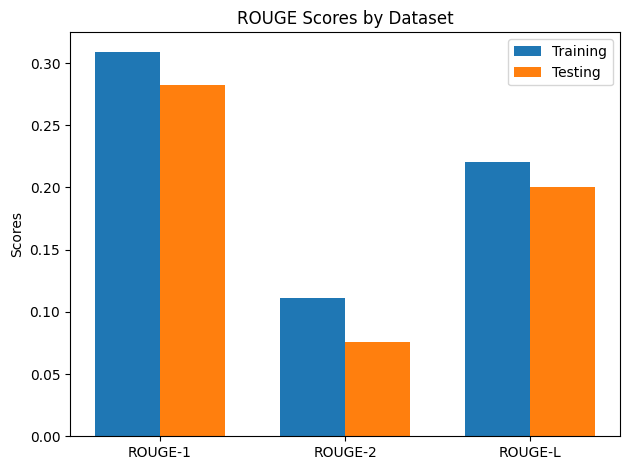

In [28]:
import matplotlib.pyplot as plt

# ROUGE scores
labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
train_scores = [train_metrics["eval_rouge1"], train_metrics["eval_rouge2"], train_metrics["eval_rougeL"]]
test_scores = [test_metrics["eval_rouge1"], test_metrics["eval_rouge2"], test_metrics["eval_rougeL"]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


Inference

For facebook/bart-large-cnn, you need to prefix your input depending on the task you're working on. For summarization you should prefix your input as shown below:



In [22]:
text = "summarize: IN THE HIGH COURT OF JUDICATURE AT PATNA CRIMINAL MISCELLANEOUS No.377321 Arising Out of PS. Case No. 114 Year 2021 Thana BEGUSARAI MUFFASIL District 1. Munni Devi Female aged about 39 years wife of Mr. Subodh Singh Rinku Devi Female aged about 37 years wife of Mr. Santosh Singh 3. Komal Kumari Female aged about 18 years daughter of Mr. Santosh Chhoti Kumari Female aged about 14 years daughter of Mr. Subodh Singh All resident of Village Mohanpur P.S. Muffasil District Begusarai ... Petitioner s The State of Bihar ... Opposite Party s For the Petitioner s For the State For the Informant Mr. Ajay Kumar Thakur Advocate Mr. Md. Arif APP Mr. Nasrul Huda Khan Advocate CORAM: HONOURABLE MR. JUSTICE AHSANUDDIN AMANULLAH ORAL JUDGMENT Date : 06 08 2021 The matter has been heard via video conferencing. 2. The case has been taken up out of turn on the basis of motion slip filed by learned counsel for the petitioner on 26.07.2021 which was allowed 3. Heard Mr. Ajay Kumar Thakur learned counsel for the petitioners Mr. Md. Arif learned Additional Public Prosecutorfor the State and Mr. Nasrul Huda Khan learned counsel for the informant. 4. The petitioners apprehend arrest in connection with Muffasil PS Case No. 1121 dated 23.02.2021 instituted Patna High Court CR. MISC. No.377321 dt.06 08 2021 under Sections 147 148 149 341 323 324 448 379 302 427 354 of the Indian Penal Code 5. The allegation against the petitioners no. 1 and 2 is that they assaulted the mother of the informant with iron rod and stick and also snatched the gold chain and ear ring whereas the petitioner no. 3 is said to have assaulted the sister of the informant with stick and thereafter it is alleged that all the accused including other male members of the family of the petitioner had entered into the house and looted Rs. 27 000 and further against the petitioner no. 4 is that she had also bitten the sister of the informant and all the accused are said to have damaged the motorcycle belonging to the father of the informant by iron rod and stones and had also taken away three mobile phones from the house. It is alleged that the father of the informant was killed due to assault by the accused. 6. Learned counsel for the petitioners submitted that both the families were agnates and they have been falsely implicated. It was submitted that no reason has been assigned in the FIR for the occurrence whereas accused Santosh Singh of the present case has lodged Muffasil PS Case No. 1121 on the same day for the same occurrence where it is alleged that the informant of the present case along with his brothers had Patna High Court CR. MISC. No.377321 dt.06 08 2021 teased and harassed one of the petitioners and when the family members of the petitioners confronted the informant they were abused and assaulted along with other family members. Learned counsel submitted that the deceased is the own uncle of co accused Santosh Singh Subodh Singh and Randhir Kumar and both the sides are neighbours. Learned counsel submitted that the case is false also for the reason that there is no injury report of the mother of the informant and as far as the sister of the informant is concerned the injury report shows only one lacerated wound above left half upper lip 1â€ x 1 2â€ and no sign of bite was found by the doctor. Thus it was submitted that the injury itself appears to be superficial. It was submitted that the entire family including the petitioners who are female members having clean antecedent have been implicated with ulterior motive and as far as the death of the father of the informant is concerned the assault on him is attributed to the other male co accused and not the petitioners. It was submitted that another aspect of the matter is that in the FIR itself it is alleged that when other male members of the petitioners who are also co accused were assaulting the father of the informant the police had arrived and thus if the same is true then there could not have been any further assault on the father of the informant and Patna High Court CR. MISC. No.377321 dt.06 08 2021 the accused would also have been arrested there itself on 22.02.2021 but neither any case was lodged nor arrest made on 22.02.2021 and only after the case was instituted on 23.02.2021 the male members of the petitioners who are accused in the present case were arrested. It was submitted that the informant side had blocked the state highway and indulged in brick batting with the police for which Muffasil PS Case No. 1121 dated 23.02.2021 under Sections 147 148 341 323 504 353 332 of the Indian Penal Code was also instituted in which the informant of the present case and others are accused 7. Learned APP submitted that the petitioners are alleged to have assaulted the mother and bitten the sister of the 8. Learned counsel for the informant submitted that the father of the informant has died due to assault. However it was not controverted that the assault on the father of the informant is attributed to the male co accused in the case and not the petitioners and also that there is no injury report with regard to the mother of the informant as also that only a lacerated wound on the upper lip of the sister of the informant has been found by the doctor as noted in the injury report. 9. Having considered the facts and circumstances of Patna High Court CR. MISC. No.377321 dt.06 08 2021 the case and submissions of learned counsel for the parties in the tentative view of the Court the allegations against the petitioners who have been made accused along with their other male members are not corroborated by the material brought before the police inasmuch as there is no injury report with regard to the mother of the informant and further that the sister of the informant has suffered only a lacerated wound above the left half upper lip and the petitioners are ladies without any criminal antecedent the Court is inclined to allow their prayer for grant of pre arrest bail 10. Accordingly in the event of arrest or surrender before the Court below within six weeks from today the petitioners be released on bail upon furnishing bail bonds of Rs 25 000 each with two sureties of the like amount each to the satisfaction of the learned Chief Judicial Magistrate Begusarai in Muffasil PS Case No. 1121 subject to the conditions laid down in Section 438(2) of the Code of Criminal Procedure 1973 and furtherthat one of the bailors shall be a close relative of the petitioners that the petitioners and the bailors shall execute bond and give undertaking with regard to good behaviour of the petitioners andthat the petitioners shall cooperate with the Court and Patna High Court CR. MISC. No.377321 dt.06 08 2021 the police prosecution Any violation of the terms and conditions of the bonds or undertaking or failure to cooperate shall lead to cancellation of their bail bonds. 11. It shall also be open for the prosecution to bring any violation of the foregoing conditions of bail by the petitioners to the notice of the Court concerned which shall take immediate action on the same after giving opportunity of hearing to the petitioner(s 12. The petition stands disposed of in the (Ahsanuddin Amanullah J J. Alam "

# 9. Text Summarization Function
Using summarize_text, we can tokenize the text and use the input_ids for generating summary from the model with model.generate():

In [23]:
import torch

def summarize_text(input_text):

    text = "summarize: " + input_text

    inputs = tokenizer(text, max_length=MAX_SOURCE_LENGTH, truncation=True, return_tensors="pt").input_ids
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Move the model to the GPU
    model.to(device)

    # Move the inputs tensor to the GPU
    inputs = inputs.to(device)

    # Generate outputs
    outputs = model.generate(inputs, max_new_tokens=MAX_TARGET_LENGTH, do_sample=False)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return summary

# 10. Text Summarization Execution
These code segment executes the summarize_text function on sample data from the training and testing datasets to generate summaries and print them.

Using the first sample of train dataset

In [24]:
print(legal_data["train"][0]["Summary"])

The issue whether a company involved in arbitration proceedings may continue the arbitration proceedings even after CIRP has been been approved by COC of the company was considered by the division bench of Supreme Court consisting of Justice AM Khanwilkar and Dinesh Maheswari in the matters between  Fourth Dimension Solutions Ltd. v. Ricoh India Ltd. Civil Appeal No. –5908 of 2021 decided on 21.1.2022. The facts of this are defendant Ricoh owed the appellant Rs.511 crores. It is stated that NCLT has approved a resolution plan that dismisses the appellant’s (Fourth Dimension Solutions Ltd.) claims, even though the appellant is the highest operational creditor of the respondent company Ricoh India. The Supreme Court also upheld the resolution plan, despite the appellant’s objection that the same decision was pending before NCLAT. However, while the higher court approved the plan, it directed NCLAT to decide on the merits of appellant’s objection to the substantive resolution plan. Despit

In [25]:
summarize_text(legal_data["train"][0]["Case"])

'It was brought to the notice of the Court that the appellant had preferred some appeal before the National Company Law Appellate Tribunal and it was still pending at the relevant time. This Court in paragraph 160 of the judgment directed that the said appeal shall proceed on merits. In our opinion it was sufficient for'

Using the first sample of test dataset

In [26]:
summarize_text(legal_data["test"][0]["Summary"])

'Section 86(1)(f) of the Electricity Act, 2003, vests statutory jurisdiction with the State Electricity Commission to adjudicate upon disputes between licensees and generating companies and to refer any dispute for arbitration. This judgment was passed in the case of Chief General Manager (IPC) M P Power Trading'

In [27]:
summarize_text(legal_data["test"][0]["Case"])

'The Madhya Pradesh Electricity Board entered into a Power Purchase Agreement (PPA) with the respondent under which it was to establish a mini hydro electric project on a built and operate basis. The PPA was terminated by the Board under Clause 12.1 of the PPA seeking to resolve the dispute by'

**Visualization of Generated Summaries:**

In [29]:
# Example Texts and Summaries
example_texts = [legal_data["test"][i]["Case"] for i in range(3)]
example_summaries = [summarize_text(legal_data["test"][i]["Case"]) for i in range(3)]

for i in range(3):
    print(f"Example {i + 1}:")
    print("Text:", example_texts[i])
    print("Summary:", example_summaries[i])
    print("="*50)

Example 1:
Text: Reportable IN THE CIVIL APPELLATE JURISDICTION Civil Appeal No 10521 Arising out of SLP(C) No 57517) Chief General ManagerM P Power Trading Co Ltd & Anr Appellant(s) Narmada Equipments Pvt Ltd JUDGMENT Dr Dhananjaya Y Chandrachud J Leave granted. This appeal arises from a judgment and order of a learned Single Judge of the High Court of Madhya Pradesh dated 30 November 2016 where it appointed an Arbitrator in the dispute between the parties in an application1 filed by the respondent under Section 11(6) of the Arbitration and Conciliation Act 19962. The genesis of the matter is from when the Madhya Pradesh Electricity Board3 entered into a Power Purchase Agreement4 on 20 May 1999 with the respondent. “AC No 15” “1996 Act” 2 Under the PPA the respondent was to establish a mini hydro electric project on a built and operate basis. However the PPA was terminated on 27 September 2001 by the Board. The respondent initially filed a writ petition5 challenging the termination of

In [32]:
# Create a DataFrame
df = pd.DataFrame({
    'Metric': labels,
    'Training': train_scores,
    'Testing': test_scores
})

# Save to CSV
df.to_csv('/content/rouge_scores.csv', index=False)

# Save ROUGE scores visualization
fig.savefig('/content/rouge_scores.png')

# Save text and summary examples to a text file
with open('/content/summary_examples.txt', 'w') as f:
    for i in range(3):
        f.write(f"Example {i + 1}:\n")
        f.write(f"Text: {example_texts[i]}\n")
        f.write(f"Summary: {example_summaries[i]}\n")
        f.write("="*50 + "\n")